In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

### Generate Dataset

In [3]:
from scipy.stats import multivariate_normal as mvn

N = 50000
x_dim = 1
y_dim = 1
noise_std_true = 0.5


# Generate data
#The dataset 1 is unimodal, the dataset 2 is multimodal

dataset_nb = 2

if dataset_nb == 1:
    b_true = np.random.randn(y_dim).astype(np.float32)   
    w_true = np.random.randn(x_dim, y_dim).astype(np.float32) 
    x = np.linspace(-10., 100., N)[None].T
    x = np.float32(x)
    noise = noise_std_true * np.random.randn(N,y_dim).astype(np.float32)
    y = np.matmul((x-50)**2, w_true)/100. + b_true + noise
    
elif dataset_nb == 2:
    radius = np.abs(np.random.normal(loc=0., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    
    radius = np.abs(np.random.normal(loc=10., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x2 = radius * np.cos(theta)
    y2 = radius * np.sin(theta)
    
    x = np.vstack([x1, x2])
    y = np.vstack([y1, y2])

In [4]:
x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)

In [5]:
samples = np.hstack([x,y])

#### Load Data

In [6]:
f = open('../data/2dsamples_new3.npy','rb')
data = np.load(f, allow_pickle=True)

x = data[:,0:1]
y = data[:,1:]

#### Normalize data

2.7915405287041755 3.1367152280621764


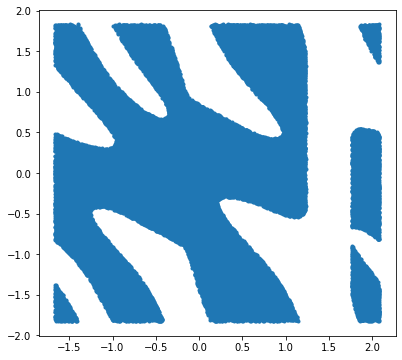

In [7]:
x_mean, x_std = np.mean(x), np.std(x)
y_mean, y_std = np.mean(y), np.std(y)
x = x - x_mean
y = y - y_mean
x /= x_std
y /= y_std
fig,ax = plt.subplots()
fig.set_size_inches(6.4, 6)
plt.plot(x[:,0], y[:,0], ".")

N = x.shape[0]
print(x_mean, y_mean)

In [8]:
samples = np.hstack([x, y])

#### Learn Using VAE

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [34]:
input_dim = 2
latent_dim = 2

prior = tfd.MultivariateNormalDiag(tf.zeros(latent_dim))

In [74]:
encoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
#     Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
#     tfpl.MultivariateNormalTriL(latent_dim)
    Dense(2*latent_dim)
    ,
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[...,:latent_dim], scale_diag=tf.math.exp(t[...,latent_dim:])
    ))
    ,
    
    tfpl.KLDivergenceAddLoss(prior, weight=.7, 
#                             test_points_fn=lambda q: q.sample(50),
#                             test_points_reduce_axis=0,
                            use_exact_kl=True)
])

In [75]:
decoder = Sequential([
    Dense(128, activation='relu', input_shape=(latent_dim,)),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
#     Dense(input_dim)
    Dense(2*input_dim),
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[...,:input_dim], scale_diag=tf.math.exp(t[...,input_dim:])
    ))
#     Dense(tfpl.MultivariateNormalTriL.params_size(input_dim)),
#     tfpl.MultivariateNormalTriL(input_dim)
])

In [76]:
vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))

#### Train VAE

In [77]:
def loss_function(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))

In [78]:
vae.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [79]:
history = vae.fit(samples, samples, epochs=20)

Epoch 1/20
1731/1731 [==============================] - 3s 1ms/step - loss: 71.3033
Epoch 2/20
1731/1731 [==============================] - 2s 1ms/step - loss: 38.7839
Epoch 3/20
1731/1731 [==============================] - 2s 1ms/step - loss: 33.8704
Epoch 4/20
1731/1731 [==============================] - 3s 1ms/step - loss: 30.6542
Epoch 5/20
1731/1731 [==============================] - 2s 1ms/step - loss: 29.8926
Epoch 6/20
1731/1731 [==============================] - 2s 1ms/step - loss: 29.0471
Epoch 7/20
1731/1731 [==============================] - 2s 1ms/step - loss: 29.0331
Epoch 8/20
1731/1731 [==============================] - 2s 1ms/step - loss: 28.8028
Epoch 9/20
1731/1731 [==============================] - 2s 999us/step - loss: 27.0856
Epoch 10/20
1731/1731 [==============================] - 2s 1ms/step - loss: 26.6878
Epoch 11/20
1731/1731 [==============================] - 2s 1ms/step - loss: 26.3207
Epoch 12/20
1731/1731 [==============================] - 2s 1ms/step - l

#### Try reconstructions

In [80]:
samples_reconstructed = vae(samples)

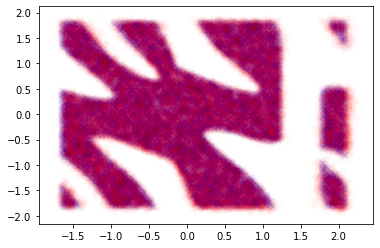

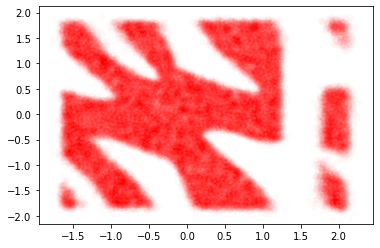

In [81]:
plt.figure()
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'or', alpha=0.01)
plt.plot(samples[:,0], samples[:,1], 'xb', alpha=0.01)

plt.figure()
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'or', alpha=0.01)


#### See the encodings

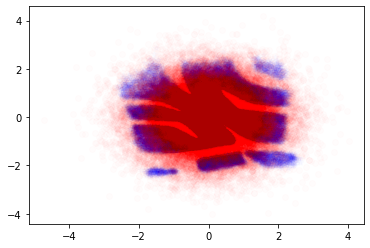

In [82]:
samples_encoded = encoder(samples)
samples_prior = prior.sample(50000)

plt.plot(samples_encoded[:,0], samples_encoded[:,1], '*b', alpha=0.01)
# plt.show()
# plt.plot(samples_encoded[:,2], samples_encoded[:,3], '*b', alpha=0.01)
# plt.show()
# plt.plot(samples_encoded[:,4], samples_encoded[:,5], '*b', alpha=0.01)
# plt.show()

plt.plot(samples_prior[:,0], samples_prior[:,1], 'or', alpha=0.01)

#### See the reconstructions from the prior

In [85]:
samples_from_prior = decoder(samples_prior).sample()

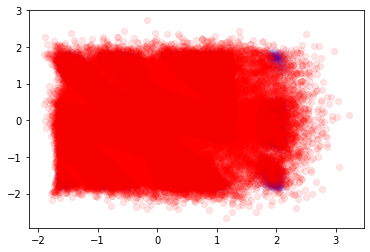

In [86]:
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'ob', alpha=0.01)
plt.plot(samples_from_prior[:,0], samples_from_prior[:,1], 'or', alpha=0.1)


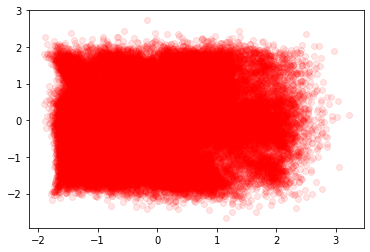

In [87]:
plt.plot(samples_from_prior[:,0], samples_from_prior[:,1], 'or', alpha=0.1)
